# Tải thư viện cần thiết

In [ ]:
! pip install git+https://github.com/huggingface/trl.git
! pip install transformers accelerate bitsandbytes peft datasets
! pip install tiktoken

  Cloning https://github.com/huggingface/trl.git to /tmp/pip-req-build-zms1p_bt
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-zms1p_bt
  Resolved https://github.com/huggingface/trl.git to commit 3979cccad4574ddc51e3268645caa7efa943b291
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for trl: filename=trl-0.26.0.dev0-py3-none-any.whl size=505722 sha256=c6dea287e752c7eb29faede27a278104248f577a77d957954e9f45ce47e4c330
  Stored in directory: /tmp/pip-ephem-wheel-cache-gh1pta98/wheels/0e/8f/95/dfd1c9271445f7e7e2fcfd9dfdcc8fabf9adc68edd4f2ea5fd
Successfully built trl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 15.9 MB/s eta 0:00:00


In [ ]:
! pip install -U trl==0.10.1 --no-cache-dir  # Phiên bản mới nhất 12/2025
! pip install -U transformers datasets accelerate peft bitsandbytes --no-cache-dir
! pip install evaluate rouge_score sacrebleu bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.8 MB/s eta 0:00:00


# Thiết lập đường dẫn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

ROOT_MAPPINGS = {
    'hao-1': '/content/drive/MyDrive/TDTU/HK7/Natural_Language_Processing/FinalTerm/',
    'hao-2': '/content/drive/MyDrive/TDTU/HK7/NLP/FinalTerm/',
    'hao-tdtu': '/content/drive/MyDrive/HK7/Natural_Language_Processing/FinalTerm/',
    'another-hao': '/content/drive/MyDrive/TDTU/Natural_Language_Processing/FinalTerm/',
}

ROOT = ROOT_MAPPINGS["another-hao"]
BASE_DIR = os.path.join(ROOT, 'Decoder_only')
DATASETS = os.path.join(BASE_DIR, 'Datasets')
MODELS = os.path.join(DATASETS, 'Models')

# tokenized_hf_data = os.path.join(DATASETS, 'tokenized_data')
classify_data = os.path.join(DATASETS, 'Dataset03.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Khai báo thư viện

In [ ]:
import pandas as pd
import json
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import math

import torch
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,
    TrainingArguments, EarlyStoppingCallback
)
from trl import SFTTrainer
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from datasets import load_dataset, Dataset
import pandas as pd

# Khởi tạo mô hình

In [ ]:
model_id = "Qwen/Qwen3-0.6B"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    attn_implementation="sdpa",
    dtype=torch.float16,
    low_cpu_mem_usage=True,
)

model.gradient_checkpointing_enable()
model.config.use_cache = False
model.config.use_flash_attn = True

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.padding_side = 'right'

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
    model.resize_token_embeddings(len(tokenizer))

print(tokenizer.pad_token)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

<|endoftext|>


In [ ]:
model = prepare_model_for_kbit_training(model)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Qwen3 dùng các module này
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    modules_to_save=None,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 2,293,760 || all params: 598,343,680 || trainable%: 0.3834


# Tải và xử lý dữ liệu

In [ ]:
df = pd.read_csv(classify_data)
df = df.dropna(subset=['product_name', 'question', 'answer'])

# Xây dựng hàm định dạng chuỗi
def format_conversation(row):
    messages = [
        {"role": "system", "content": f"Sản phẩm: {row['product_name'].strip()}"},
        {"role": "user",   "content": row['question'].strip()},
        {"role": "assistant", "content": row['answer'].strip()}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=False   # không thêm "assistant\n" ở cuối khi train
    )
    return text

df["text"] = df.apply(format_conversation, axis=1)

# Tạo Dataset, nhưng GIỮ LẠI các cột gốc
dataset = Dataset.from_pandas(df)


# Chia thành 80% train, 20% tạm thời
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)

# Chia tiếp 20% thành validation + test (10% - 10%)
valid_test = dataset_split["test"].train_test_split(test_size=0.5, seed=42)

# Gom lại
dataset_final = {
    "train": dataset_split["train"],
    "validation": valid_test["train"],
    "test": valid_test["test"]
}

print(
    f"Train: {len(dataset_final['train'])} mẫu | "
    f"Validation: {len(dataset_final['validation'])} mẫu | "
    f"Test: {len(dataset_final['test'])} mẫu"
)

Train: 37203 mẫu | Validation: 4650 mẫu | Test: 4651 mẫu


In [ ]:
print(dataset_final["train"][4]["text"])

<|im_start|>system
Sản phẩm: Dép xốp khách sạn<|im_end|>
<|im_start|>user
Mình cảm ơn bạn nhiều nhé, mình sẽ cân nhắc đặt hàng<|im_end|>
<|im_start|>assistant
<think>

</think>

Cảm ơn bạn đã quan tâm đến sản phẩm của chúng tôi. Chúc bạn một ngày tốt lành<|im_end|>



# Visualize

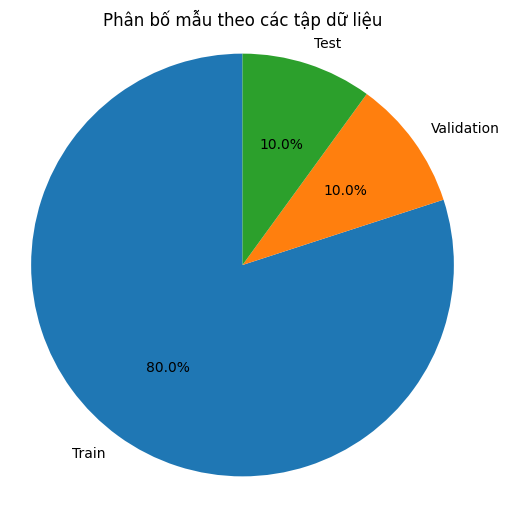

In [ ]:
import matplotlib.pyplot as plt

# Lấy số lượng mẫu
sizes = [
    len(dataset_final["train"]),
    len(dataset_final["validation"]),
    len(dataset_final["test"])
]

labels = ["Train", "Validation", "Test"]

# Vẽ biểu đồ tròn
plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Phân bố mẫu theo các tập dữ liệu")
plt.axis("equal")  # đảm bảo hình tròn cân đối
plt.show()


In [ ]:
def compute_token_lengths(dataset, tokenizer, text_field="text"):
    lengths = []
    for x in dataset[text_field]:
        ids = tokenizer(x, add_special_tokens=True)['input_ids']
        lengths.append(len(ids))
    return np.array(lengths)

def compute_range_stats(lengths, thresholds=[128, 256, 384, 512, 768]):
    lengths = np.array(lengths)
    total = len(lengths)

    ranges = []
    prev = 0
    for t in thresholds:
        count = ((lengths >= prev) & (lengths <= t)).sum()
        pct = count / total * 100
        ranges.append((f"{prev}–{t}", pct))
        prev = t + 1

    # Khoảng cuối
    count = (lengths >= prev).sum()
    pct = count / total * 100
    ranges.append((f">= {prev}", pct))

    return ranges

def build_distribution_table(train_ranges, val_ranges, test_ranges):
    df = pd.DataFrame({
        "Range": [r[0] for r in train_ranges],
        "Train (%)": [round(r[1], 2) for r in train_ranges],
        "Validation (%)": [round(r[1], 2) for r in val_ranges],
        "Test (%)": [round(r[1], 2) for r in test_ranges],
    })
    return df

In [ ]:
def plot_max_len_ratio(train_dist, val_dist, test_dist):
    ranges = [x[0] for x in train_dist]
    train_vals = [x[1] for x in train_dist]
    val_vals   = [x[1] for x in val_dist]
    test_vals  = [x[1] for x in test_dist]

    x = np.arange(len(ranges))
    width = 0.25

    plt.figure(figsize=(12, 6))

    plt.bar(x - width, train_vals, width, label="Train")
    plt.bar(x, val_vals, width, label="Validation")
    plt.bar(x + width, test_vals, width, label="Test")

    plt.xticks(x, ranges, rotation=45)
    plt.ylabel("Tỉ lệ mẫu (%)")
    plt.title("So sánh phân bố độ dài token theo các khoảng")
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_avg_comparison(train_avg, val_avg, test_avg):
    names = ["Train", "Validation", "Test"]
    values = [train_avg, val_avg, test_avg]

    plt.figure(figsize=(8, 6))
    plt.bar(names, values)
    plt.ylabel("Average Token Length")
    plt.title("So sánh độ dài token trung bình giữa các tập")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
# Tính token length cho 3 tập
train_lengths = compute_token_lengths(dataset_final["train"], tokenizer)
val_lengths   = compute_token_lengths(dataset_final["validation"], tokenizer)
test_lengths  = compute_token_lengths(dataset_final["test"], tokenizer)

# Phân loại theo khoảng
thresholds = [128, 256, 384, 512]

train_ranges = compute_range_stats(train_lengths, thresholds)
val_ranges   = compute_range_stats(val_lengths, thresholds)
test_ranges  = compute_range_stats(test_lengths, thresholds)

distribution = build_distribution_table(train_ranges, val_ranges, test_ranges)
display(distribution)

,Range,Train (%),Validation (%),Test (%)
0,0–128,88.88,88.75,88.24
1,129–256,11.09,11.20,11.74
2,257–384,0.03,0.04,0.02
3,385–512,0.01,0.00,0.00
4,>= 513,0.00,0.00,0.00


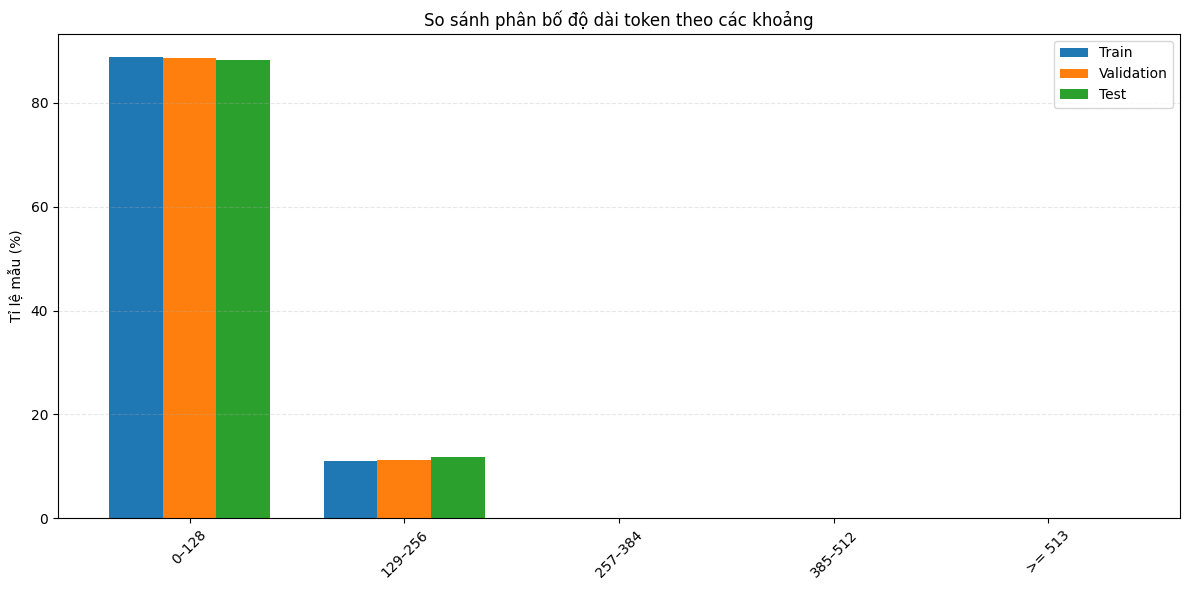

In [ ]:
plot_max_len_ratio(train_ranges, val_ranges, test_ranges)

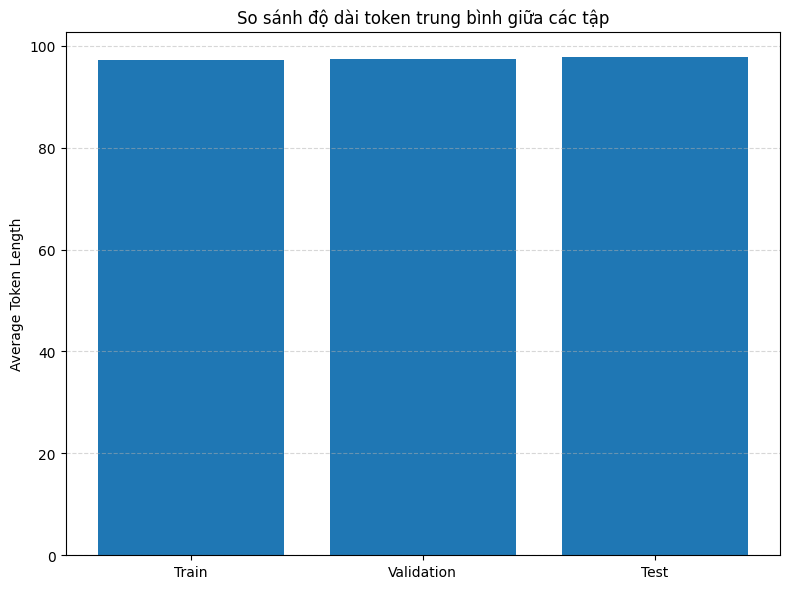

In [ ]:
train_avg = np.mean(train_lengths)
val_avg   = np.mean(val_lengths)
test_avg  = np.mean(test_lengths)

plot_avg_comparison(train_avg, val_avg, test_avg)

## Tokenize

In [ ]:
def tokenize_function(examples):
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        max_length=256,
        padding=False,
    )
    tokenized["labels"] = tokenized["input_ids"].copy()

    return tokenized

tokenized_dataset = {
    "train": dataset_final["train"].map(
        tokenize_function,
        batched=True,
        remove_columns=[c for c in dataset_final["train"].column_names if c != "text"],
    ),
    "validation": dataset_final["validation"].map(
        tokenize_function,
        batched=True,
        remove_columns=[c for c in dataset_final["validation"].column_names if c != "text"],
    ),
    "test": dataset_final["test"].map(
        tokenize_function,
        batched=True,
        remove_columns=[c for c in dataset_final["test"].column_names if c != "text"],
    ),
}

Map:   0%|          | 0/37203 [00:00<?, ? examples/s]

Map:   0%|          | 0/4650 [00:00<?, ? examples/s]

Map:   0%|          | 0/4651 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_dataset["test"][0])

{'text': '<|im_start|>system\nSản phẩm: Combo 3 Bộ quần áo bé gái trễ vai mẫu Trái Tim cho bé từ 8kg đến 22kg<|im_end|>\n<|im_start|>user\nTôi không chắc sản phẩm này có phù hợp với con tôi không. Tôi có thể đổi trả sản phẩm nếu không vừa không?<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\nBạn có thể đổi trả sản phẩm Combo 3 Bộ quần áo bé gái trễ vai mẫu Trái Tim trong vòng 7 ngày kể từ ngày nhận hàng nếu sản phẩm không vừa hoặc không đúng như mô tả. Bạn có thể liên hệ với bộ phận chăm sóc khách hàng của chúng tôi để được hỗ trợ thêm.<|im_end|>\n', 'input_ids': [151644, 8948, 198, 50, 40707, 79479, 25, 53023, 220, 18, 129029, 132543, 129970, 89451, 129826, 489, 124417, 39486, 129643, 1163, 124900, 9354, 2600, 89451, 94576, 220, 23, 7351, 128263, 220, 17, 17, 7351, 151645, 198, 151644, 872, 198, 140000, 53037, 130052, 85636, 79479, 96535, 28776, 129831, 128319, 128250, 390, 128296, 53037, 13, 129718, 28776, 128254, 128726, 129477, 85636, 79479, 128725, 53037, 128727, 53037, 

In [ ]:
print(tokenized_dataset["test"][0]["text"])

<|im_start|>system
Sản phẩm: Combo 3 Bộ quần áo bé gái trễ vai mẫu Trái Tim cho bé từ 8kg đến 22kg<|im_end|>
<|im_start|>user
Tôi không chắc sản phẩm này có phù hợp với con tôi không. Tôi có thể đổi trả sản phẩm nếu không vừa không?<|im_end|>
<|im_start|>assistant
<think>

</think>

Bạn có thể đổi trả sản phẩm Combo 3 Bộ quần áo bé gái trễ vai mẫu Trái Tim trong vòng 7 ngày kể từ ngày nhận hàng nếu sản phẩm không vừa hoặc không đúng như mô tả. Bạn có thể liên hệ với bộ phận chăm sóc khách hàng của chúng tôi để được hỗ trợ thêm.<|im_end|>



In [ ]:
# Data collator tự động pad khi train
from trl import DataCollatorForCompletionOnlyLM

data_collator = DataCollatorForCompletionOnlyLM(
    response_template="<|im_start|>assistant\n",
    tokenizer=tokenizer,
    mlm=False,
)

In [ ]:
output_dir = os.path.join(BASE_DIR, "qwen3-raw-finetuned")
final_dir = os.path.join(BASE_DIR, "qwen3-raw-final")

print(output_dir)
print(final_dir)

/content/drive/MyDrive/TDTU/Natural_Language_Processing/FinalTerm/Decoder_only/qwen3-raw-finetuned
/content/drive/MyDrive/TDTU/Natural_Language_Processing/FinalTerm/Decoder_only/qwen3-raw-final


# Cấu hình mô hình

In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to="none",

    # Tham số Huấn luyện chính
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    optim="adamw_torch_fused",
    learning_rate=3e-4,
    lr_scheduler_type="cosine",

    warmup_ratio=0.03,
    weight_decay=0.01,  # tránh overfitting
    max_grad_norm=1.0,

    # Logging và Đánh giá
    logging_steps=10,
    save_strategy="epoch", # Lưu checkpoint sau mỗi epoch vào Drive
    eval_strategy="epoch",
    load_best_model_at_end=True,
    gradient_checkpointing=True,

    # Kỹ thuật Tăng tốc
    group_by_length=False,
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    fp16=True,
    metric_for_best_model="eval_loss",
    seed=42,
    data_seed=42,

    # remove_unused_columns=False,
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_final["train"],
    eval_dataset=dataset_final["validation"],
    tokenizer=tokenizer,
    dataset_text_field="text",      # SFTTrainer tự tokenize
    max_seq_length=256,            # tự truncate
    packing=False,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/37203 [00:00<?, ? examples/s]

Map:   0%|          | 0/4650 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:412: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
The model is already on multiple devices. Skipping the move to device specified in `args`.


# Load checkpoint để train tiếp (nếu có)

In [ ]:
def get_latest_checkpoint(output_dir):
    if not os.path.exists(output_dir):
        return None

    checkpoints = [
        os.path.join(output_dir, d) for d in os.listdir(output_dir)
        if d.startswith("checkpoint-")
    ]

    if not checkpoints:
        return None

    # Sort theo số checkpoint
    checkpoints = sorted(
        checkpoints,
        key=lambda x: int(x.split("-")[-1])
    )

    return checkpoints[-1]   # trả checkpoint mới nhất


latest_checkpoint = get_latest_checkpoint(output_dir)
if latest_checkpoint:
    print(f" Đang tiếp tục train từ checkpoint: {latest_checkpoint}")
else:
    print("Không tìm thấy checkpoint — bắt đầu train từ đầu")

 Đang tiếp tục train từ checkpoint: /content/drive/MyDrive/HK7/Natural_Language_Processing/FinalTerm/Decoder_only/qwen3-raw-finetuned/checkpoint-9304


# Training

In [ ]:
trainer.train(
    resume_from_checkpoint=latest_checkpoint
)

# Lưu model đã fine-tune
trainer.save_model(final_dir)
tokenizer.save_pretrained(final_dir)
print(f"Model đã lưu vào thư mục {output_dir}")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Epoch,Training Loss,Validation Loss
1,0.680500,0.607020


KeyboardInterrupt: 

In [ ]:
# train tiếp ở hao-2
trainer.train(
    resume_from_checkpoint=latest_checkpoint
)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Epoch,Training Loss,Validation Loss
2,0.487900,0.553239
3,0.493200,0.526883
4,0.401100,0.520209


In [ ]:
# train tiếp ở hao-tdtu
trainer.train(
    resume_from_checkpoint=latest_checkpoint
)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Epoch,Training Loss,Validation Loss
5,0.349500,0.526600


TrainOutput(global_step=11630, training_loss=0.07722313844839869, metrics={'train_runtime': 2598.1726, 'train_samples_per_second': 71.595, 'train_steps_per_second': 4.476, 'total_flos': 4.849220636010086e+16, 'train_loss': 0.07722313844839869, 'epoch': 5.0})

In [ ]:
# Lưu model đã fine-tune
trainer.save_model(final_dir)
tokenizer.save_pretrained(final_dir)
print(f"Model đã lưu vào thư mục {output_dir}")

Model đã lưu vào thư mục /content/drive/MyDrive/HK7/Natural_Language_Processing/FinalTerm/Decoder_only/qwen3-raw-finetuned


In [ ]:
print(trainer)

# Biểu đồ train loss

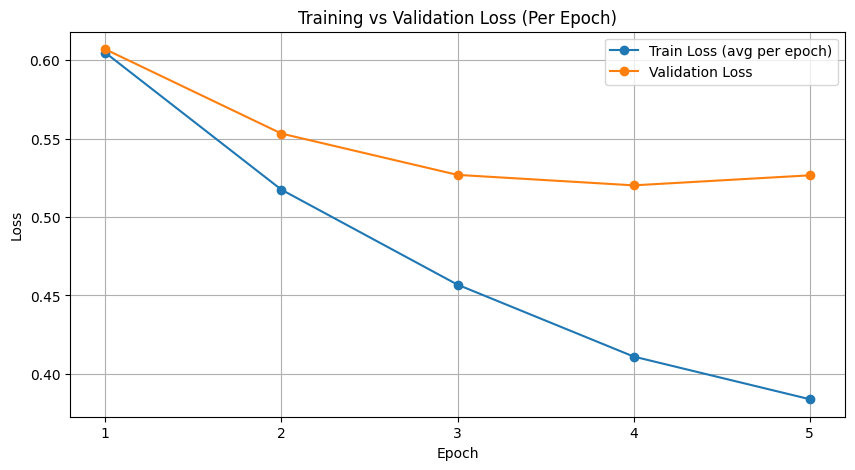

In [ ]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt

def load_epoch_losses(output_dir):

    logs = []

    # Tìm tất cả trainer_state.json
    json_paths = glob.glob(f"{output_dir}/**/trainer_state.json", recursive=True)

    for path in json_paths:
        with open(path, "r") as f:
            state = json.load(f)
            if "log_history" in state:
                logs.extend(state["log_history"])

    df = pd.DataFrame(logs)

    # Chỉ giữ record có epoch (step logs không có)
    df = df[df["epoch"].notna()]

    # # ----- Train Loss -----
    train_df = df[df["loss"].notna()]
    train_epoch_loss = train_df.groupby(train_df["epoch"].round())["loss"].mean()
    train_epoch_loss = train_epoch_loss[train_epoch_loss.index > 0]

    # # ----- Validation Loss -----
    val_df = df[df["eval_loss"].notna()]
    val_epoch_loss = val_df.groupby(val_df["epoch"].round())["eval_loss"].mean()


    return train_epoch_loss, val_epoch_loss


def plot_epoch_loss(train_epoch_loss, val_epoch_loss):

    plt.figure(figsize=(10, 5))

    plt.plot(train_epoch_loss.index, train_epoch_loss.values,
             marker="o", label="Train Loss (avg per epoch)")

    plt.plot(val_epoch_loss.index, val_epoch_loss.values,
             marker="o", label="Validation Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss (Per Epoch)")
    plt.grid(True)
    plt.legend()
    plt.xticks(train_epoch_loss.index)  # Hiển thị các epoch integer

    plt.show()

train_loss, val_loss = load_epoch_losses(output_dir)
plot_epoch_loss(train_loss, val_loss)

# Load mô hình đã finetune

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    final_dir,
    device_map="auto",
    dtype=torch.bfloat16,
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(final_dir)
tokenizer.padding_side = "right"

# Đánh giá mô hình

In [ ]:
def evaluate_loss_ppl(trainer, dataset):
    print("=== Evaluate Loss + Perplexity ===")

    results = trainer.evaluate(
    )

    test_loss = results["eval_loss"]
    ppl = math.exp(test_loss)

    print(f"Test Loss = {test_loss:.4f}")
    print(f"Test Perplexity = {ppl:.4f}")

    return test_loss, ppl

test_loss, test_ppl = evaluate_loss_ppl(trainer, tokenized_dataset["test"])


=== Evaluate Loss + Perplexity ===


Test Loss = 0.5654
Test Perplexity = 1.7602


In [ ]:
def show_test_samples(model, tokenizer, dataset, num_samples=5, max_new_tokens=200):
    model.eval()
    samples = random.sample(list(dataset), num_samples)

    for i, row in enumerate(samples, 1):
        print("\n" + "=" * 100)
        print(f"🟦 SAMPLE {i}")

        # ===========================
        # 1) Build inference prompt — KHÔNG có ground truth
        # ===========================
        prompt = tokenizer.apply_chat_template(
            [
                {"role": "system", "content": f"Sản phẩm: {row['product_name']}"},
                {"role": "user", "content": row['question']},
            ],
            tokenize=False,
            add_generation_prompt=True  # rất quan trọng
        )

        # Tokenize
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        # ===========================
        # 2) Model generate
        # ===========================
        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                eos_token_id=tokenizer.eos_token_id,
            )

        decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        # ===========================
        # 3) Tách phần model sinh ra khỏi prompt
        # ===========================
        model_answer = decoded.replace(prompt, "").strip()

        # ===========================
        # 4) Print everything
        # ===========================
        print("🔶 PROMPT:")
        print(prompt)

        print("\n🟩 QUESTION:")
        print(row["question"])

        print("\n🟥 GROUND TRUTH:")
        print(row["answer"])

        print("\n🟦 MODEL OUTPUT:")
        print(model_answer)

        print("=" * 100)



# Gọi hàm
show_test_samples(
    model=model,
    tokenizer=tokenizer,
    dataset=dataset_final["test"],
    num_samples=5,
    max_new_tokens=200
)


🟦 SAMPLE 1
🔶 PROMPT:
<|im_start|>system
Sản phẩm: Vòng tay phong thuỷ đá cẩm thạch tím<|im_end|>
<|im_start|>user
Tôi muốn hủy đơn hàng này ngay lập tức!<|im_end|>
<|im_start|>assistant


🟩 QUESTION:
Tôi muốn hủy đơn hàng này ngay lập tức!

🟥 GROUND TRUTH:
Chúng tôi rất tiếc vì bạn muốn hủy đơn hàng. Bạn có thể hủy đơn hàng trong vòng 24 giờ kể từ khi đặt hàng. Vui lòng liên hệ với chúng tôi để được hỗ trợ.

🟦 MODEL OUTPUT:
system
Sản phẩm: Vòng tay phong thuỷ đá cẩm thạch tím
user
Tôi muốn hủy đơn hàng này ngay lập tức!
assistant
<think>

</think>

Chúng tôi rất tiếc vì bạn muốn hủy đơn hàng. Bạn có thể hủy đơn hàng bằng cách liên hệ với bộ phận chăm sóc khách hàng của chúng tôi qua số điện thoại 0902360296 hoặc email support@sendo.vn.

🟦 SAMPLE 2
🔶 PROMPT:
<|im_start|>system
Sản phẩm: đầm nữ cực xinh<|im_end|>
<|im_start|>user
Thôi được rồi. Tôi sẽ cân nhắc thêm.<|im_end|>
<|im_start|>assistant


🟩 QUESTION:
Thôi được rồi. Tôi sẽ cân nhắc thêm.

🟥 GROUND TRUTH:
Cảm ơn bạn đã quan tâ

# Inference

In [ ]:
def chat_with_model(product_name, question, model=model, tokenizer=tokenizer,
                    max_new_tokens=200, temperature=0.7, top_p=0.9):
    """
    Hàm dùng model đã fine-tune để trả lời câu hỏi về sản phẩm.
    Truyền vào tên sản phẩm và câu hỏi.
    """

    model.eval()

    # Build chat prompt theo đúng template Qwen 3
    prompt = tokenizer.apply_chat_template(
        [
            {"role": "system", "content": f"Sản phẩm: {product_name}"},
            {"role": "user", "content": question},
        ],
        tokenize=False,
        add_generation_prompt=True
    )

    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            eos_token_id=tokenizer.eos_token_id
        )

    # Decode full sequence
    decoded = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Tách phần model sinh ra khỏi prompt
    answer = decoded.replace(prompt, "").strip()

    return answer

In [ ]:
product = "Dép xốp khách sạn"
question = "Mặt hàng này còn không?"

generated_answer = chat_with_model(product, question)
print("Model trả lời:", generated_answer)


Model trả lời: system
Sản phẩm: Dép xốp khách sạn
user
Mặt hàng này còn không?
assistant
<think>

</think>

Sản phẩm Dép xốp khách sạn còn 20 chiếc ạ.
